<a href="https://colab.research.google.com/github/RiRyCasals/tech-AI-project/blob/main/01_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder, CAE, DAE

---

このノートブックでは，画像生成の基本となる autoencoder（オートエンコーダー）を学び，画像のノイズ除去を行います．

## Autoencoderとは

---

出力データ $\grave{x}$ が 入力データ $x$ に近づくように学習する，シンプルな構造を持ったニューラルネットワークの一つ．

入力データ $x$ を 中間層 $z$ に圧縮しようとする Encoder（エンコーダー） と，
中間層 $z$ を 入力データ $x$ に復元しようとする Decoder（デコーダー）から構成される．

![image](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRIxod0BMClzJQjiW4PPOhRWyiRJLNv4kN-fQ&usqp=CAU)

## CAE とは

---

CAE : Convolutional Autoencoder

オートエンコーダーのエンコーダーとデコーダーにCNNを用いたもの．

![image](https://cdn-ak.f.st-hatena.com/images/fotolife/m/motojapan/20170815/20170815034208.png)

## DAE とは

---

DAE : Denoising Autoencoder

入力データ $x$ にノイズを加えた $\check{x}$ をモデルの入力データとするもの．

$\check{x}$ を入力データとし，オリジナルの入力データ $x$ を生成するように学習する．

![image](https://miro.medium.com/max/724/1*qKiQ1noZdw8k05-YRIl6hw.jpeg)

# ノイズ除去
---

以下の順番で行う．

1. データセットの読み込み
2. ノイズデータの生成
3. CAEモデルの構築
4. 学習と予測

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

## データセットの読み込み
--- 

データの読み込みと整形を行う

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train / 255.
x_test = x_test / 255.

11501568/11490434 [==============================] - 0s 0us/step


## ノイズデータの生成
---

マスキングノイズ と ガウシアンノイズ の2種類のノイズデータを生成する

In [ ]:
def plot_image_2column(index, img1, img2):
    plt.subplot(121)
    plt.axis("off")
    plt.imshow(img1[index][:, :, 0])
    plt.subplot(122)
    plt.axis("off")
    plt.imshow(img2[index][:, :, 0])
    plt.show()

def plot_image_3column(index, img1, img2, img3):
    plt.subplot(131)
    plt.axis("off")
    plt.imshow(img1[index][:, :, 0])
    plt.subplot(132)
    plt.axis("off")
    plt.imshow(img2[index][:, :, 0])
    plt.subplot(133)
    plt.axis("off")
    plt.imshow(img3[index][:, :, 0])
    plt.show()

### マスキングノイズ
---

画像の一部の値を 0 にするノイズ．


In [ ]:
def make_masking_noise_data(data, percent=0.1):
    masking = np.random.binomial(n=1, p=percent, size=data.shape)
    return data * masking

In [ ]:
x_train_masked = make_masking_noise_data(x_train)
x_test_masked = make_masking_noise_data(x_test)

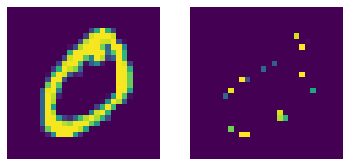

In [ ]:
plot_image_2column(1, x_train, x_train_masked)

### ガウシアンノイズ
---

ガウシアン分布を元にしたノイズ．

In [ ]:
def make_gussian_noise_data(data, scale=0.8):
    gussian_data = data + np.random.normal(loc=0, scale=scale, size=data.shape)
    return np.clip(gussian_data, 0, 1)

In [ ]:
x_train_gussian = make_gussian_noise_data(x_train)
x_test_gussian = make_gussian_noise_data(x_test)

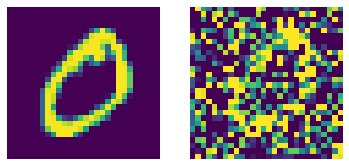

In [ ]:
plot_image_2column(1, x_train, x_train_gussian)

## CAEモデルの構築
---



In [ ]:
def create_model():
    autoencoder = Sequential()
    autoencoder.add(Conv2D(16, (3, 3), 1, activation="relu", padding="same", input_shape=(28, 28, 1)))
    autoencoder.add(MaxPooling2D((2, 2), padding="same"))
    autoencoder.add(Conv2D(8, (3, 3), 1, activation="relu", padding="same"))
    autoencoder.add(MaxPooling2D((2, 2), padding="same"))
    autoencoder.add(Conv2D(8, (3, 3), 1, activation="relu", padding="same"))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(16, (3, 3), 1, activation="relu", padding="same"))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(1, (3, 3), 1, activation="sigmoid", padding="same"))
    return autoencoder

In [ ]:
autoencoder = create_model()
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 8)        0

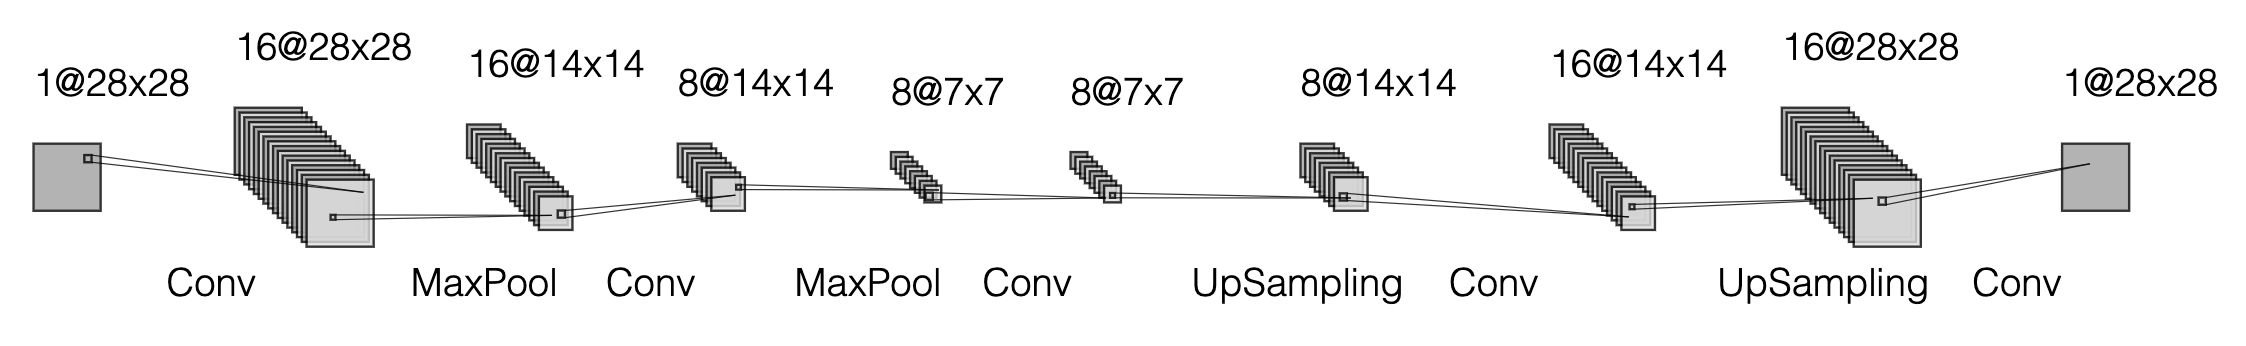

上記のような図は [NN SVG](http://alexlenail.me/NN-SVG/LeNet.html) などで作成することができる．

In [ ]:
autoencoder_for_mask_noise = create_model()
autoencoder_for_mask_noise.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
autoencoder_for_gussian_noise = create_model()
autoencoder_for_gussian_noise.compile(optimizer="adam", loss="binary_crossentropy")

## 学習と予測
---


### マスキングノイズを入力とした学習と予測
---

In [ ]:
autoencoder_for_mask_noise.fit(x_train_masked, x_train, epochs=20, batch_size=20, shuffle=True)

Epoch 1/20
3000/3000 [==============================] - 56s 18ms/step - loss: 0.2075
Epoch 2/20
3000/3000 [==============================] - 56s 19ms/step - loss: 0.1895
Epoch 3/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1863
Epoch 4/20
3000/3000 [==============================] - 56s 19ms/step - loss: 0.1842
Epoch 5/20
3000/3000 [==============================] - 58s 19ms/step - loss: 0.1826
Epoch 6/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1818
Epoch 7/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1813
Epoch 8/20
3000/3000 [==============================] - 56s 19ms/step - loss: 0.1809
Epoch 9/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1806
Epoch 10/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1803
Epoch 11/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1800
Epoch 12/20
3000/3000 [==============================] - 55s 18

In [ ]:
masked_preds = autoencoder_for_mask_noise.predict(x_test_masked)

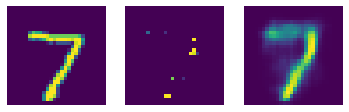

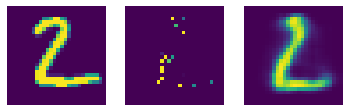

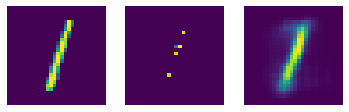

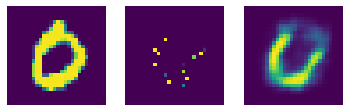

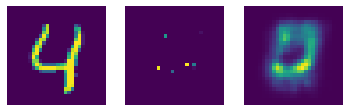

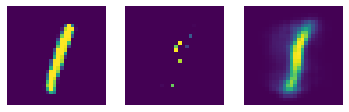

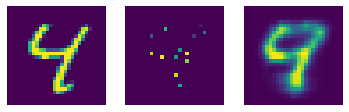

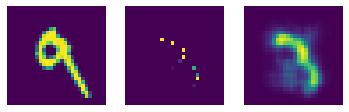

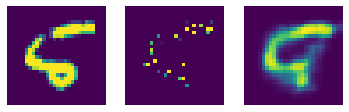

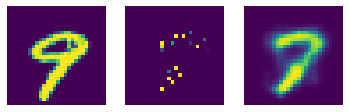

In [ ]:
for i in range(10):
    plot_image_3column(i, x_test, x_test_masked, masked_preds)

### マスキングノイズを入力とした学習と予測
---

In [ ]:
autoencoder_for_gussian_noise.fit(x_train_gussian, x_train, epochs=20, batch_size=20, shuffle=True)

Epoch 1/20
3000/3000 [==============================] - 56s 18ms/step - loss: 0.1820
Epoch 2/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1579
Epoch 3/20
3000/3000 [==============================] - 56s 19ms/step - loss: 0.1528
Epoch 4/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1498
Epoch 5/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1478
Epoch 6/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1468
Epoch 7/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1461
Epoch 8/20
3000/3000 [==============================] - 56s 19ms/step - loss: 0.1455
Epoch 9/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1451
Epoch 10/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1448
Epoch 11/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.1445
Epoch 12/20
3000/3000 [==============================] - 55s 18

In [ ]:
gussian_preds = autoencoder_for_gussian_noise.predict(x_test_gussian)

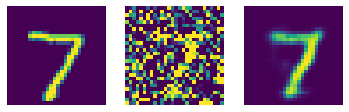

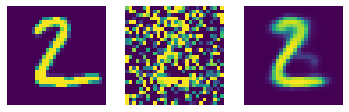

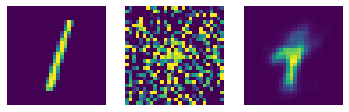

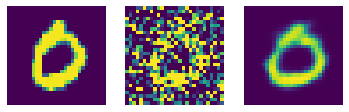

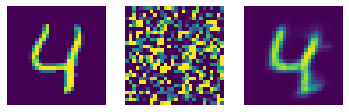

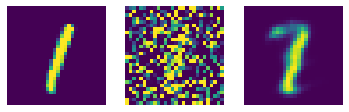

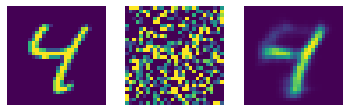

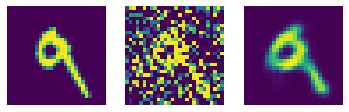

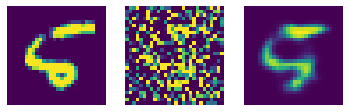

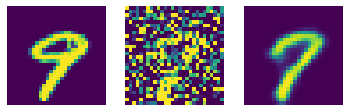

In [ ]:
for i in range(10):
    plot_image_3column(i, x_test, x_test_gussian, gussian_preds)